In [16]:
import numpy as np
import pandas as pd

import scripts
import os
import subprocess
import importlib

from Bio import SeqIO
import matplotlib.pyplot as plt
%matplotlib inline


from Bio.SeqFeature import SeqFeature, FeatureLocation

In [2]:
importlib.reload(scripts)

<module 'scripts' from '/net/holy-nfsisilon/ifs/rc_labs/eddy_lab/users/lmerk/phage_groupII/scripts.py'>

In [2]:
data_dir = 'data/'

# Infernal subdir
infernal_dir = os.path.join(data_dir, 'infernal/')

# new_alignments subdir
new_alignments = os.path.join(infernal_dir, 'cluster1')

# Genomes subdir
genomes_dir = os.path.join(data_dir, 'genomes/')
metadata_dir = os.path.join(genomes_dir, 'inphared_metadata/')
metadata_path = os.path.join(metadata_dir, '14Dec2023_data.tsv')
metadata = pd.read_csv(metadata_path, sep='\t').rename(columns={'Accession': 'target_name'})
genbank_dir = os.path.join(genomes_dir, 'groupII_millard/')
actual_genomes = pd.read_csv(f'{genomes_dir}actual_genomes.txt', header=None)[0].unique()

# Window and defense
window_dir = os.path.join(genomes_dir, 'gII_intron_5kb_windows/')
bakta_dir = os.path.join(data_dir, 'bakta_output')
pharokka_dir = os.path.join(data_dir, "pharokka_output")
defense_dir = os.path.join(data_dir, 'defensefinder/bakta_defense')

# Script output subdir
script_output = os.path.join(data_dir, 'script_output/')
genbank_out_directory = os.path.join(script_output, "updated_genomes")

g2_df = pd.read_csv(f'{script_output}g2_df.csv')
shit_list = ['KU878088', 'AP008983', 'MF360957', 'LC680884', 'KT887559', 'MN270258']

In [187]:
preprocess = False

In [167]:
def extract_hit_df_easy(filename, filt = True):
    initial = 0
    colspecs = []

    with open(filename, 'r') as infile:
        data = infile.readlines()
        for i in data[1:2]:
            widths = [len(col)+1 for col in i.split()]
            # print(i.split())

    for n in range(0, len(widths)):
        if n == len(widths)-1:
            colspecs.append((initial, -1))
        else:
            colspecs.append((initial, initial + widths[n]))
        initial +=  widths[n]

    hit_df = pd.read_fwf(filename, skipfooter=10, skiprows=2, colspecs = colspecs, names=['target_name', 'accession', 'query_name', 'accession_2', 'mdl', \
                                                        'mdl_from', 'mdl_to', 'seq_from', 'seq_to', 'strand', 'trunc', 'pass', 'gc', 'bias', \
                                                        'score', 'E-value', 'inc', 'description_of_target'])
    if filt == True:
        hit_df = hit_df.loc[hit_df['E-value'] < 0.1]
        
    # Some are on +, some -, make a stard and end to make comparing easier later
    hit_df['start'] = hit_df[['seq_from','seq_to']].min(axis=1)
    hit_df['end'] = hit_df[['seq_from','seq_to']].max(axis=1)

    hit_df['length'] = hit_df['end'] - hit_df['start']
    
    final = hit_df[~hit_df['target_name'].isin(shit_list)]
    
    final['intronID'] = final['target_name'] + '_I_' + final['seq_from'].astype(str)
    
    # remove the |
    final['original_target_name'] = final['target_name'].copy()
    final['target_name'] = final['original_target_name'].str.replace('|', '_', regex=False)

    return final.sort_values('target_name')

____

In [189]:
c1_tblout = os.path.join(new_alignments, 'cluster1_millard.tblout')
c1_df = extract_hit_df_easy(c1_tblout)
c1_df.target_name.unique()

array(['KY695241', 'LC680885', 'LC727904', 'MK448731', 'MK448888',
       'MN091626', 'MN270259', 'MT835809', 'MT836027', 'MT836071',
       'MT836602', 'MW248466', 'MW749003', 'MZ422438', 'NC_007581',
       'NC_030940', 'NC_031039', 'NC_043027', 'ON107264'], dtype=object)

In [200]:
clean_c1 = c1_df[(c1_df['target_name'].duplicated()) | (c1_df['length'] > 200)]
clean_c1

,target_name,accession,query_name,accession_2,mdl,mdl_from,mdl_to,seq_from,seq_to,strand,...,pass,gc,bias,score,E-value,inc,description_of_target,start,end,length
29,MK448731,-,BUCT_millard_anytrunc,-,cm,1,609,14162,14377,+,...,1,0.43,0.0,31.5,2.000000e-04,!,"Streptococcus phage Javan33, complete genome.",14162,14377,215
28,MK448888,-,BUCT_millard_anytrunc,-,cm,1,609,12134,12349,+,...,1,0.43,0.0,31.5,2.000000e-04,!,"Streptococcus phage Javan26, complete genome.",12134,12349,215
2,MN270259,-,BUCT_millard_anytrunc,-,cm,1,609,80550,81083,+,...,1,0.42,5.5,401.7,6.900000e-123,!,"Streptococcus phage phi-SgaBSJ31_rum, complete...",80550,81083,533
4,MT835809,-,BUCT_millard_anytrunc,-,cm,23,306,14523,14231,-,...,5,0.41,0.3,105.4,4.500000e-28,!,UNVERIFIED: Bacteriophage sp. clone scaffold_7...,14231,14523,292
1,MT836071,-,BUCT_millard_anytrunc,-,cm,1,609,22014,21408,-,...,1,0.44,6.4,442.3,6.900000e-136,!,UNVERIFIED: Bacteriophage sp. clone scaffold_1...,21408,22014,606
21,MT836071,-,BUCT_millard_anytrunc,-,cm,522,603,19646,19560,-,...,5,0.44,0.0,42.6,5.800000e-08,!,UNVERIFIED: Bacteriophage sp. clone scaffold_1...,19560,19646,86
6,MZ422438,-,BUCT_millard_anytrunc,-,cm,463,595,120721,120855,+,...,5,0.41,0.1,82.9,7.400000e-21,!,"Listeria phage LPJP1, complete genome.",120721,120855,134
9,MZ422438,-,BUCT_millard_anytrunc,-,cm,464,591,51114,50984,-,...,5,0.35,0.5,73.5,7.400000e-18,!,"Listeria phage LPJP1, complete genome.",50984,51114,130
12,MZ422438,-,BUCT_millard_anytrunc,-,cm,513,607,163974,163874,-,...,1,0.34,0.3,52.4,4.100000e-11,!,"Listeria phage LPJP1, complete genome.",163874,163974,100
0,ON107264,-,BUCT_millard_anytrunc,-,cm,1,609,85334,85935,+,...,1,0.44,0.9,556.8,1.600000e-172,!,"Bacillus phage BUCT083, complete genome.",85334,85935,601


In [195]:
for genome in c1_df.target_name.unique():
    if genome not in g2_df.target_name.unique():
        print(genome)

LC727904
MT835809


In [196]:
def update_genbank_only_g2_new_alignments(genbank_path, hit_df):
    # Iterate over actual genomes
    for genome in actual_genomes:
        # Check if genome is present in the DataFrame
        if genome in hit_df['target_name'].values:
            # Read the GenBank record corresponding to the genome
            genome_path = f'{genbank_path}/{genome}_double_and_intron_and_defense.gbff'
            record = SeqIO.read(genome_path, 'genbank')

            # Filter hits DataFrame for the current genome
            this_genome_df = hit_df.loc[hit_df['target_name'] == genome]

            # Sort hits DataFrame by start position
            this_genome_df = this_genome_df.sort_values(by='start')

            # Initialize prev_hit with the first hit
            prev_hit = this_genome_df.iloc[0]

            # Iterate over hits to check for hits within 1 kb of each other
            for index, row in this_genome_df.iterrows():
                start = int(row['start'])
                end = int(row['end'])

                # Check if current hit is within 1 kb of the previous hit
                if start - prev_hit['end'] <= 1000:
                    # Process the genome with at least two hits within 1 kb

                    # Iterate over hits again to add features to GenBank record
                    for index, row in this_genome_df.iterrows():
                        start = int(row['start'])
                        end = int(row['end'])

                        # Create feature and add qualifiers
                        feature = SeqFeature(FeatureLocation(start, end), type='ncRNA')
                        feature.qualifiers['label'] = [row['query_name']]
                        feature.qualifiers['query_name'] = [row['accession_2']]
                        feature.qualifiers['E-value'] = [row['E-value']]

                        # Set strand
                        if row['strand'] == '-':
                            feature.strand = -1
                        else:
                            feature.strand = +1

                        # Append feature to GenBank record
                        record.features.append(feature)

                    # Save modified GenBank record
                    modified_genbank_file = f"data/script_output/cluster1/{genome}_with_g2.gb"
                    SeqIO.write(record, modified_genbank_file, 'genbank')

                    # Break out of loop since processing is done for this genome
                    break

                prev_hit = row  # Update previous hit for next iteration

In [197]:
update_genbank_only_g2_new_alignments(genbank_out_directory, clean_c1)

______

In [95]:
g2_hits_pass = pd.read_csv(f'{script_output}g2_hits_pass.csv')

In [107]:
sbatch_params = "-p eddy -t 60 -c 4 -n 1 --mem-per-cpu=6G -o /dev/null"

# Iterate through rows in the DataFrame
for index, row in g2_hits_pass.iterrows():
    fasta_file = os.path.join(genbank_dir, f'{row.target_name}/{row.target_name}.fna')

    window = 2000
    start = row.start-window
    end = row.end+window

    if start - 1 < 1:
        start = 1
    if end > row['Genome Length (bp)']:
        end = row['Genome Length (bp)']

    cmd = f"esl-sfetch -c {start}..{end} {fasta_file} {row.target_name} > {script_output}window_fna/{row.intronID}.fna"
    sbatch_command = f"sbatch {sbatch_params} --wrap='{cmd}'"
    # print(sbatch_command)
    subprocess.run(sbatch_command, shell=True)

In [110]:
subprocess.run("cat /n/eddy_lab/users/lmerk/phage_groupII/data/script_output/window_fna/*.fna > /n/eddy_lab/users/lmerk/phage_groupII/data/script_output/all_windows.fna", shell=True)

CompletedProcess(args='cat /n/eddy_lab/users/lmerk/phage_groupII/data/script_output/window_fna/*.fna > /n/eddy_lab/users/lmerk/phage_groupII/data/script_output/all_windows.fna', returncode=0)

_____

# Clutser 2

In [154]:
cluster_2 = os.path.join(infernal_dir, 'cluster2')


In [172]:
tblout = os.path.join(cluster_2, 'CST_millard.tblout')
hit_df = extract_hit_df_easy(tblout)
hit_df.target_name.unique()

array(['MN091626', 'MN270258', 'MN270259', 'MT836027', 'MT836071',
       'MW749003', 'MZ422438', 'NC_007581', 'NC_031039', 'NC_043027',
       'ON107264'], dtype=object)

These are all in cluster 2 already, note many of them are only hiting D5D6

In [173]:
c2_tblout = os.path.join(cluster_2, 'cluster2_millard.tblout')
c2_df = extract_hit_df_easy(c2_tblout)
c2_df.target_name.unique()

array(['KY695241', 'LC680885', 'MN091626', 'MT836027', 'MT836071',
       'MT836602', 'MW248466', 'MW749003', 'MZ422438', 'NC_007581',
       'NC_030940', 'NC_031039', 'NC_043027', 'ON107264'], dtype=object)

In [178]:
c2_df[(c2_df['target_name'].duplicated()) | (c2_df['length'] > 200)]


,target_name,accession,query_name,accession_2,mdl,mdl_from,mdl_to,seq_from,seq_to,strand,...,pass,gc,bias,score,E-value,inc,description_of_target,start,end,length
11,LC680885,-,CST_millard,-,cm,1,555,191615,192078,+,...,1,0.29,53.3,169.8,4.000000e-42,!,"Staphylococcus phage S6 DNA, complete genome.",191615,192078,463
8,MN091626,-,CST_millard,-,cm,1,555,50111,50691,+,...,1,0.32,51.2,297.5,2.800000e-78,!,"Staphylococcus phage PALS_2, complete genome.",50111,50691,580
13,MW248466,-,CST_millard,-,cm,1,555,111217,111604,+,...,1,0.35,22.9,164.4,1.400000e-40,!,"Staphylococcus phage MarsHill, complete genome.",111217,111604,387
0,MW749003,-,CST_millard,-,cm,1,555,25613,25019,-,...,1,0.34,41.2,531.9,1.000000e-144,!,"Bacillus phage vB_BspM_Internexus, complete ge...",25019,25613,594
10,MZ422438,-,CST_millard,-,cm,1,555,120219,120890,+,...,1,0.33,57.3,174.4,2.100000e-43,!,"Listeria phage LPJP1, complete genome.",120219,120890,671
19,MZ422438,-,CST_millard,-,cm,409,555,137168,137009,-,...,5,0.36,0.1,96.8,1.900000e-21,!,"Listeria phage LPJP1, complete genome.",137009,137168,159
9,MZ422438,-,CST_millard,-,cm,1,555,164479,163854,-,...,1,0.29,83.4,256.0,1.500000e-66,!,"Listeria phage LPJP1, complete genome.",163854,164479,625
12,MZ422438,-,CST_millard,-,cm,1,555,51635,50945,-,...,1,0.28,96.7,167.9,1.400000e-41,!,"Listeria phage LPJP1, complete genome.",50945,51635,690
6,NC_007581,-,CST_millard,-,cm,1,555,115302,114619,-,...,1,0.30,78.5,402.1,6.300000e-108,!,"Clostridium phage c-st, complete genome.",114619,115302,683
2,NC_031039,-,CST_millard,-,cm,1,555,121998,121506,-,...,1,0.33,33.9,403.8,2.100000e-108,!,"Bacillus phage AR9, complete genome.",121506,121998,492


In [179]:
c2_df

,target_name,accession,query_name,accession_2,mdl,mdl_from,mdl_to,seq_from,seq_to,strand,...,pass,gc,bias,score,E-value,inc,description_of_target,start,end,length
26,KY695241,-,CST_millard,-,cm,472,505,7,40,+,...,2,0.53,0.0,31.2,7.600000e-03,!,Wolbachia phage sr1WOdamA clone contig3 genomi...,7,40,33
21,LC680885,-,CST_millard,-,cm,447,553,193401,193530,+,...,1,0.36,0.1,85.4,3.500000e-18,!,"Staphylococcus phage S6 DNA, complete genome.",193401,193530,129
11,LC680885,-,CST_millard,-,cm,1,555,191615,192078,+,...,1,0.29,53.3,169.8,4.000000e-42,!,"Staphylococcus phage S6 DNA, complete genome.",191615,192078,463
8,MN091626,-,CST_millard,-,cm,1,555,50111,50691,+,...,1,0.32,51.2,297.5,2.800000e-78,!,"Staphylococcus phage PALS_2, complete genome.",50111,50691,580
20,MT836027,-,CST_millard,-,cm,448,553,7110,6996,-,...,1,0.49,0.0,89.1,3.000000e-19,!,UNVERIFIED: Bacteriophage sp. clone scaffold_1...,6996,7110,114
27,MT836071,-,CST_millard,-,cm,469,505,19619,19583,-,...,1,0.46,0.0,31.2,7.800000e-03,!,UNVERIFIED: Bacteriophage sp. clone scaffold_1...,19583,19619,36
28,MT836602,-,CST_millard,-,cm,469,518,5503,5549,+,...,5,0.49,0.0,30.1,1.600000e-02,?,UNVERIFIED: Bacteriophage sp. clone scaffold_2...,5503,5549,46
22,MW248466,-,CST_millard,-,cm,448,553,112576,112690,+,...,1,0.36,0.0,72.9,1.200000e-14,!,"Staphylococcus phage MarsHill, complete genome.",112576,112690,114
13,MW248466,-,CST_millard,-,cm,1,555,111217,111604,+,...,1,0.35,22.9,164.4,1.400000e-40,!,"Staphylococcus phage MarsHill, complete genome.",111217,111604,387
0,MW749003,-,CST_millard,-,cm,1,555,25613,25019,-,...,1,0.34,41.2,531.9,1.000000e-144,!,"Bacillus phage vB_BspM_Internexus, complete ge...",25019,25613,594


In [174]:
for genome in c2_df.target_name.unique():
    if genome not in g2_df.target_name.unique():
        print(genome)

_____

In [168]:
original_imgvr = extract_hit_df_easy(os.path.join(infernal_dir, 'g2_intron_IMGVR.tblout'))
cluster1_new = extract_hit_df_easy("/n/eddy_lab/users/lmerk/phage_groupII/data/infernal/cluster1/IMGVR/g2_intron_IMGVR.tblout")
cluster2_new = extract_hit_df_easy("/n/eddy_lab/users/lmerk/phage_groupII/data/infernal/cluster2/IMGVR/g2_c2_IMGVR.tblout")

In [170]:
# # get all the contigs so i can download the metadata from imgvr
# df = pd.DataFrame(list(original_imgvr.target_name.unique()), columns=['uvig'])
# # imgvr search only needs the first |
# df['uvig'] = df['uvig'].str.split('|').str[0]

# # Imgvr web only allows 5000 searches at a time
# total_rows = len(df)
# first_batch_size = 5000
# second_batch_size = total_rows - first_batch_size if total_rows > first_batch_size else 0

# # Save the first batch (first 5000 rows) to a CSV file
# df.iloc[:first_batch_size].to_csv('batch_1.csv', index=False, header=False)

# # Save the second batch (next batch of rows) to a CSV file
# if second_batch_size > 0:
#     df.iloc[first_batch_size:first_batch_size + second_batch_size].to_csv('batch_2.csv', index=False, header=False)

In [171]:
# df = pd.DataFrame(list(try_cluster1['original_target_name'].unique()), columns=['uvig'])

# # for esl
# df.to_csv('cluster1_contigs.txt', index=False, header=False)

In [172]:
new_genomes = []
# new with cluster 1 pull
for genome in cluster1_new.target_name.unique():
    if genome not in original_imgvr.target_name.unique():
        new_genomes.append(genome)

In [173]:
len(new_genomes)

724

In [174]:
# new with cluster 2 pull
c2_genomes = []
for genome in cluster2_new.target_name.unique():
    if genome not in original_imgvr.target_name.unique():
        c2_genomes.append(genome)

In [175]:
len(c2_genomes)

91

_____

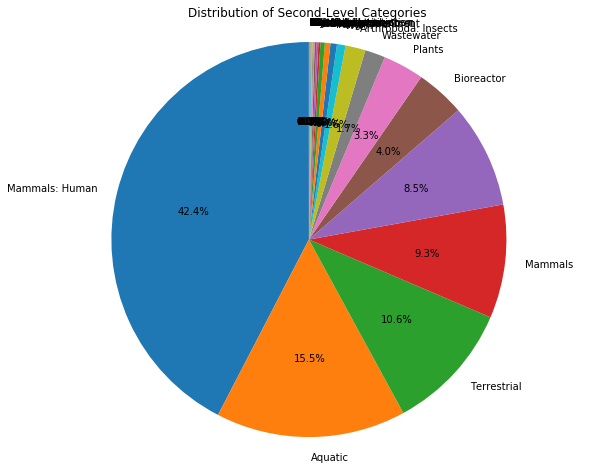

In [176]:
imgvr_metadata = pd.read_csv("imgvr_hit_metadata.csv")

# Create DataFrame
df = pd.DataFrame(imgvr_metadata.Ecosystem, columns=['Ecosystem'])

# Extract the second category
df['Second_Category'] = df['Ecosystem'].apply(lambda x: x.split(';')[1].strip() if len(x.split(';')) > 1 else None)

# Count occurrences
category_counts = df['Second_Category'].value_counts()

# Plotting
plt.figure(figsize=(10, 8))
plt.pie(category_counts, labels=category_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Distribution of Second-Level Categories')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

______

In [199]:
#2 inovirus

In [189]:
imgvr_metadata = pd.read_csv("phagescope_imgvr_metadata.tsv", sep = "\t")


In [194]:
orginal = imgvr_metadata.loc[imgvr_metadata.Phage_ID.isin(original_imgvr.original_target_name.unique())]

In [196]:
ino_list = list(orginal.loc[orginal.Taxonomy == 'Inoviridae'].Phage_ID)
ino_list

['IMGVR_UViG_3300011577_000009|3300011577|Ga0121006_100006|33464-49439',
 'IMGVR_UViG_2767802214_000001|2767802214|2767831747']

In [198]:
original_imgvr.loc[original_imgvr.original_target_name.isin(ino_list)]

,target_name,accession,query_name,accession_2,mdl,mdl_from,mdl_to,seq_from,seq_to,strand,...,bias,score,E-value,inc,description_of_target,start,end,length,intronID,original_target_name
1764,IMGVR_UViG_2767802214_000001_2767802214_276783...,-,Intron_gpII,RF00029,cm,1,93,115,191,+,...,0.0,58.9,0.000003,!,-,115.0,191.0,76.0,IMGVR_UViG_2767802214_000001|2767802214|276783...,IMGVR_UViG_2767802214_000001|2767802214|276783...
4069,IMGVR_UViG_3300011577_000009_3300011577_Ga0121...,-,Intron_gpII,RF00029,cm,1,93,6249,6325,+,...,0.0,53.5,0.000056,!,-,6249.0,6325.0,76.0,IMGVR_UViG_3300011577_000009|3300011577|Ga0121...,IMGVR_UViG_3300011577_000009|3300011577|Ga0121...


_____

In [101]:
# with open('IMGVR_hit_genomes.fna', 'r') as file:
#     data = file.read()

# # Replace all '|' with '_'
# data = data.replace('|', '_')

# # Write the modified data back to the file
# with open('modified_IMGVR_hit_genomes.fna', 'w') as file:
#     file.write(data)

In [200]:
# with open('IMGVR_c1_hit_genomes.fna', 'r') as file:
#     data = file.read()

# # Replace all '|' with '_'
# data = data.replace('|', '_')

# # Write the modified data back to the file
# with open('modified_IMGVR_c1_hit_genomes.fna', 'w') as file:
#     file.write(data)

In [205]:
def windows(intron_df, window_dir, fasta_file):
    # don't save the slurm outputs with -o /dev/null
    # sbatch_params = "-p eddy -t 60 -c 4 -n 1 --mem-per-cpu=6G"
    sbatch_params = "-p eddy -t 60 -c 4 -n 1 -J fetch_scan --mem-per-cpu=2G -o /dev/null"

    hmmscan_dir = os.path.join(window_dir, 'hmmscan')
    fna_dir = os.path.join(window_dir, 'fna')
    faa_dir = os.path.join(window_dir, 'faa')
    
    os.makedirs(hmmscan_dir, exist_ok=True)
    os.makedirs(fna_dir, exist_ok=True)
    os.makedirs(faa_dir, exist_ok=True)
    
    tblout = os.path.join(hmmscan_dir, 'tblout')
    out = os.path.join(hmmscan_dir, 'out')
    
    os.makedirs(tblout, exist_ok=True)
    os.makedirs(out, exist_ok=True)
    intron_df.loc[:, 'seq_from'] = intron_df['seq_from'].astype(int)
    intron_df.loc[:, 'seq_to'] = intron_df['seq_to'].astype(int)

    # Iterate through rows in the DataFrame
    for _, row in intron_df.iterrows():
        # If I'm large, my bounds are probably right
        if row.end - row.start > 1300:
            start = row.seq_from
            end = row.seq_to
        
        else:
            end = row.end
            if row.strand == '+':
                start = row.seq_from-1500
                end = row.seq_to
            else:
                start = row.seq_from+1500
                end = row.seq_to
        
        if row.strand == '+':
            strand = '--watson'
        else:
            strand = '--crick'
            
        if start - 1 < 1:
            start = 1
            
        faa_file = os.path.join(faa_dir, f'{row.target_name}.faa')
        cmd = f"esl-sfetch -c {start}..{end} {fasta_file} {row.target_name} | tee {os.path.join(fna_dir, f'{row.target_name}_window.fna')} | esl-translate -l 90 - | tee {faa_file} | hmmscan -o {os.path.join(out, f'{row.target_name}_hmmscan_output.out')} --tblout {os.path.join(tblout, f'{row.target_name}_hmmscan_output.tblout')} /n/eddy_lab/data/pfam-35.0/Pfam-A.hmm -"
        sbatch_command = f"sbatch {sbatch_params} --wrap='{cmd}'"
        subprocess.run(sbatch_command, shell=True)

In [ ]:
windows(original_imgvr, "./all_windows_new/", "modified_IMGVR_hit_genomes.fna")

In [206]:
# windows(cluster1_new, "./c1_windows_new/", "modified_IMGVR_c1_hit_genomes.fna")

In [88]:
def sfetch(intron_df, window_dir, fasta_file):
    # don't save the slurm outputs with -o /dev/null
    # sbatch_params = "-p eddy -t 60 -c 4 -n 1 --mem-per-cpu=6G"
    sbatch_params = "-p eddy -t 60 -c 4 -n 1 -J sfetch --mem-per-cpu=6G -o /dev/null"

    # Iterate through rows in the DataFrame
    for _, row in intron_df.iterrows():
        faa_file = os.path.join(window_dir, f'{row.target_name}.faa')
        cmd = f"esl-sfetch -c {int(row.start)}..{int(row.end)} {fasta_file} {row.target_name} | tee {row.target_name}_window.fna | esl-translate -l 60 - > {faa_file}"
        sbatch_command = f"sbatch {sbatch_params} --wrap='{cmd}'"
        subprocess.run(sbatch_command, shell=True)

In [89]:
sfetch(longs, "./c1_windows/", "modified_IMGVR_c1_hit_genomes.fna")

In [68]:
def hmmscan(intron_df, window_dir):
    """
    hmmscan a window from a FASTA file against Pfam-A

    Parameters:
    - intron_df (dataframe): like g2_hits_pass, the cleaned output of extract hits

    Note you need to wait a few seconds after running (check your jobs).
    """
    
    sbatch_params = "-p eddy -t 60 -c 4 -n 1 -J hmmscan --mem-per-cpu=6G -o /dev/null"
    target_dir = os.path.join(window_dir, 'hmmscan')
    
    for index, row in intron_df.iterrows():
        temp_protein_fasta = os.path.join(window_dir, f'{row.target_name}.faa')

        if os.path.exists(temp_protein_fasta) and os.path.getsize(temp_protein_fasta) > 0:
            hmmscan_script = f"hmmscan -o {os.path.join(target_dir, f'{row.target_name}_hmmscan_output.out')} --domtblout {os.path.join(target_dir, f'{row.target_name}_hmmscan_output.domtblout')} --tblout {os.path.join(target_dir, f'{row.target_name}_hmmscan_output.tblout')} /n/eddy_lab/data/pfam-35.0/Pfam-A.hmm {temp_protein_fasta}"
            sbatch_command = f"sbatch {sbatch_params} --wrap='{hmmscan_script}'"
            print(sbatch_command)
            subprocess.run(sbatch_command, shell=True)

In [ ]:
IMGVR_UViG_2199352008_000234_2199352008_2200191195/4995-5703

In [70]:
hmmscan(longs[0:1], "./c1_windows/")

sbatch -p eddy -t 60 -c 4 -n 1 -J hmmscan --mem-per-cpu=6G -o /dev/null --wrap='hmmscan -o ./c1_windows/hmmscan/IMGVR_UViG_2199352008_000234_2199352008_2200191195_hmmscan_output.out --domtblout ./c1_windows/hmmscan/IMGVR_UViG_2199352008_000234_2199352008_2200191195_hmmscan_output.domtblout --tblout ./c1_windows/hmmscan/IMGVR_UViG_2199352008_000234_2199352008_2200191195_hmmscan_output.tblout /n/eddy_lab/data/pfam-35.0/Pfam-A.hmm ./c1_windows/IMGVR_UViG_2199352008_000234_2199352008_2200191195.faa'
